In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore")

2024-12-10 23:02:05.359652: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Get the daily stock prices datasets of JPMorgan and Nvidia.

In [3]:
tickers = ['JPM', 'NVDA']

for ticker in tickers:
    stock_data = yf.download(ticker, start='2018-12-31', end='2022-12-31')
    
    prices = np.array(stock_data.reset_index()['Close'])
    prices_diff = prices[1:] - prices[:-1]
    prices_log = np.log(prices)
    prices_log_diff = prices_log[1:] - prices_log[:-1]
    
    df = pd.DataFrame({
        'prices': prices,
        'prices_diff': np.append([np.nan], prices_diff), 
        'prices_log': prices_log,
        'prices_log_diff': np.append([np.nan], prices_log_diff)  
    })
    
    globals()[f'{ticker}'] = df
    

print(JPM.head())
print(NVDA.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

       prices  prices_diff  prices_log  prices_log_diff
0   97.620003          NaN    4.581082              NaN
1   99.309998     1.689995    4.598246         0.017164
2   97.110001    -2.199997    4.575844        -0.022402
3  100.690002     3.580002    4.612047         0.036202
4  100.760002     0.070000    4.612741         0.000695
    prices  prices_diff  prices_log  prices_log_diff
0  3.33750          NaN    1.205222              NaN
1  3.40550      0.06800    1.225392         0.020170
2  3.19975     -0.20575    1.163073        -0.062319
3  3.40475      0.20500    1.225172         0.062099
4  3.58500      0.18025    1.276758         0.051587


In [4]:
for ticker in tickers:
    stock_data = yf.download(ticker, start='2022-12-31', end='2023-12-31')
    
    prices = np.array(stock_data.reset_index()['Close'])
    prices_diff = prices[1:] - prices[:-1]
    prices_log = np.log(prices)
    prices_log_diff = prices_log[1:] - prices_log[:-1]
    
    df = pd.DataFrame({
        'prices': prices,
        'prices_diff': np.append([np.nan], prices_diff), 
        'prices_log': prices_log,
        'prices_log_diff': np.append([np.nan], prices_log_diff)  
    })
    
    globals()[f'{ticker}_test'] = df

print(JPM_test.head())
print(NVDA_test.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

       prices  prices_diff  prices_log  prices_log_diff
0  135.119995          NaN    4.906163              NaN
1  136.380005     1.260010    4.915445         0.009282
2  135.350006    -1.029999    4.907864        -0.007581
3  137.940002     2.589996    4.926819         0.018955
4  137.369995    -0.570007    4.922678        -0.004141
   prices  prices_diff  prices_log  prices_log_diff
0  14.315          NaN    2.661308              NaN
1  14.749     0.434000    2.691175         0.029867
2  14.265    -0.483999    2.657809        -0.033366
3  14.859     0.594000    2.698606         0.040797
4  15.628     0.769000    2.749064         0.050458


#### Exploratory Data Analysis before constructing the models.

In [6]:
def plot_price_analysis(df):
    prices = df['prices'].values
    prices_diff = df['prices_diff'].values
    prices_log = df['prices_log'].values
    prices_log_diff = df['prices_log_diff'].values

    series = {
        'Close Prices': prices,
        'Differenced Prices': prices_diff,
        'Log Prices': prices_log,
        'Log Differenced Prices': prices_log_diff
    }

    colors = ['blue', 'orange', 'green', 'red']
    
    plt.figure(figsize=(12, 8))
    plt.suptitle('Close Prices Analysis (2014-2019)', fontsize=16)

    for i, (title, data) in enumerate(series.items(), 1):
        plt.subplot(2, 2, i)
        plt.plot(data, label=title, color=colors[i - 1])  
        plt.title(title)
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()

    plt.subplots_adjust(hspace=0.3)  
    plt.show()

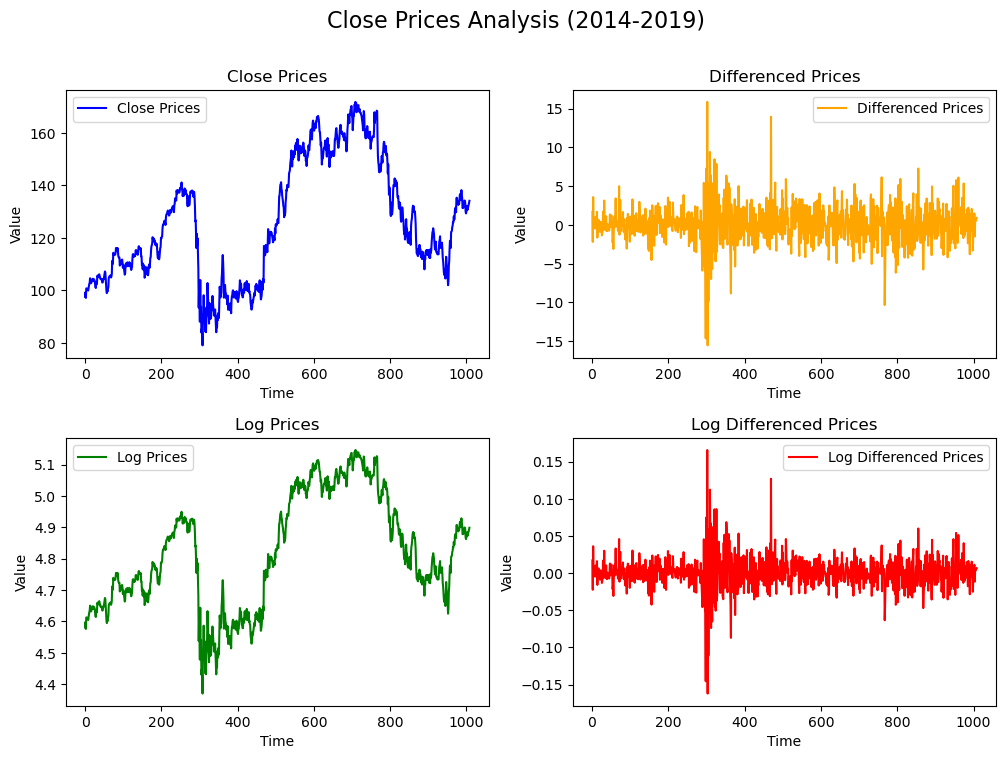

In [7]:
plot_price_analysis(JPM)

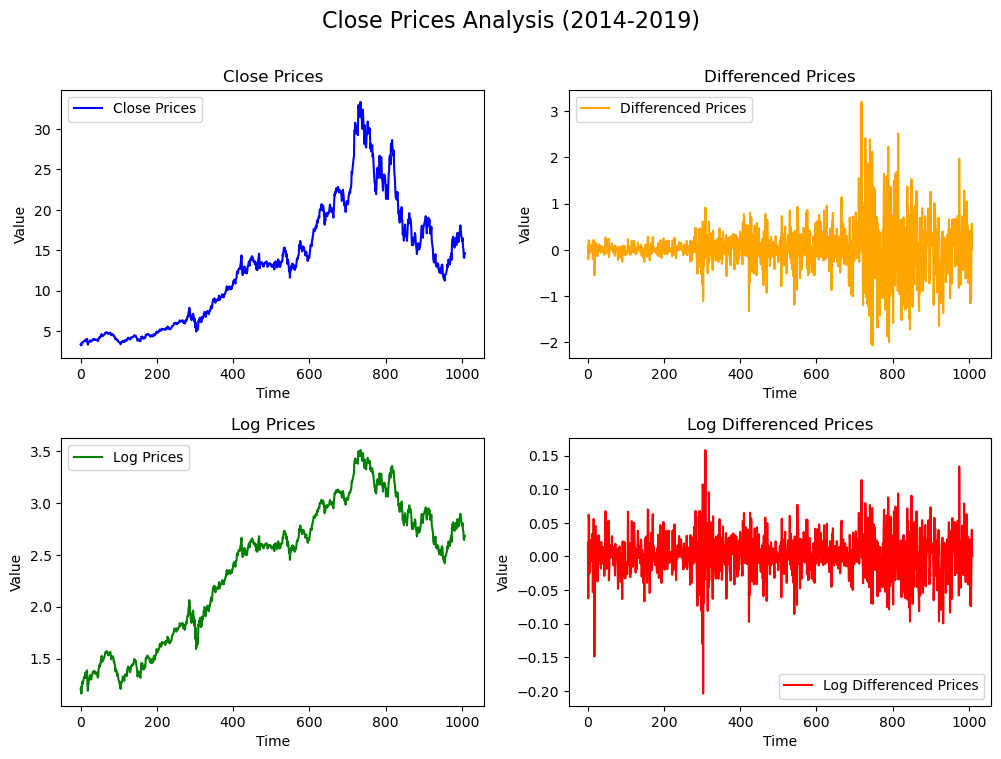

In [8]:
plot_price_analysis(NVDA)

#### Implementing the ADF and ACF/PACF test to determine the p,d,q for ARIMA model.

In [10]:
def adftest(x):
    result = adfuller(x)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [11]:
adftest(JPM['prices'])
adftest(JPM['prices_diff'].dropna())
adftest(JPM['prices_log'])
adftest(JPM['prices_log_diff'].dropna())

ADF Statistic: -1.695654
p-value: 0.433353
	1%: -3.437
	5%: -2.864
	10%: -2.568
ADF Statistic: -9.392820
p-value: 0.000000
	1%: -3.437
	5%: -2.864
	10%: -2.568
ADF Statistic: -1.830059
p-value: 0.365643
	1%: -3.437
	5%: -2.864
	10%: -2.568
ADF Statistic: -9.067318
p-value: 0.000000
	1%: -3.437
	5%: -2.864
	10%: -2.568


In [12]:
adftest(NVDA['prices'])
adftest(NVDA['prices_diff'].dropna())
adftest(NVDA['prices_log'])
adftest(NVDA['prices_log_diff'].dropna())

ADF Statistic: -1.581482
p-value: 0.492889
	1%: -3.437
	5%: -2.864
	10%: -2.568
ADF Statistic: -8.133069
p-value: 0.000000
	1%: -3.437
	5%: -2.864
	10%: -2.568
ADF Statistic: -1.574082
p-value: 0.496598
	1%: -3.437
	5%: -2.864
	10%: -2.568
ADF Statistic: -9.855048
p-value: 0.000000
	1%: -3.437
	5%: -2.864
	10%: -2.568


From the ADF tests for JPM and NVDA, we can see that the difference of prices is stationary enough. Therefore, I select the prices_diff to do the ACF and PACF test. However, the plots below are not very clear. Other methods are used to find the p and q later.

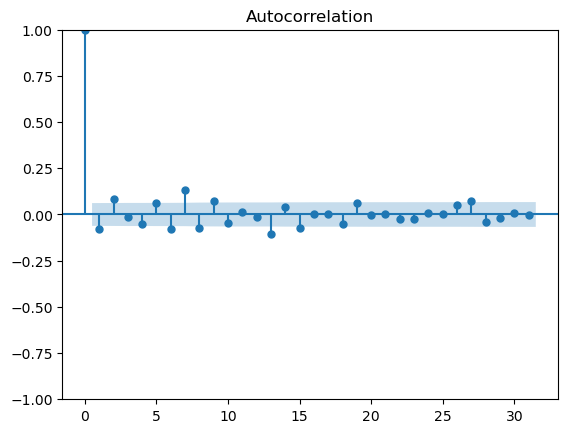

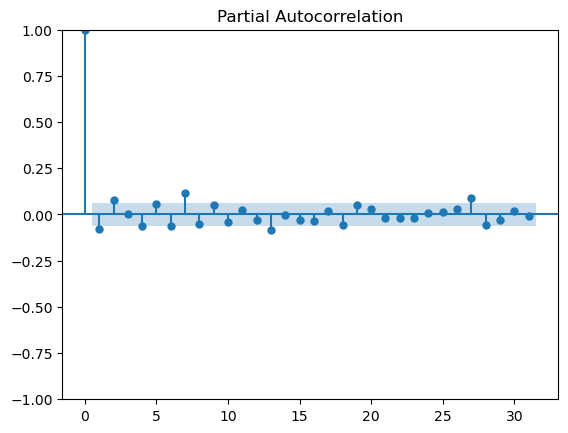

In [14]:
JPMseries = JPM['prices_diff'].dropna()
plot_acf(JPMseries)
plot_pacf(JPMseries)
plt.show()

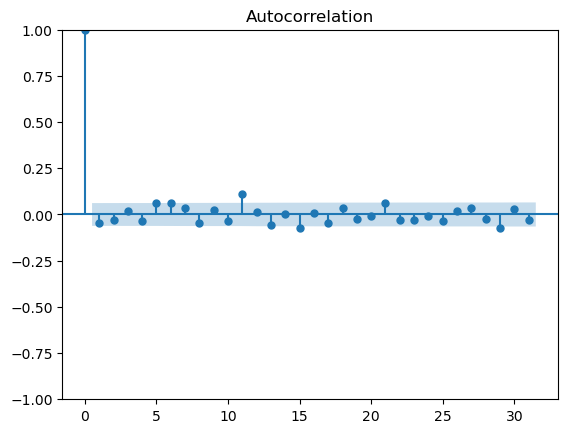

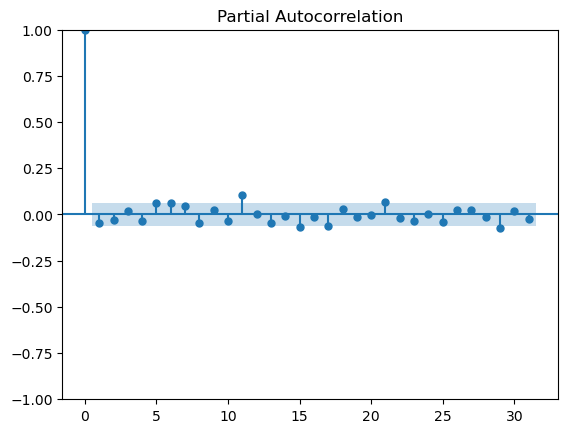

In [15]:
NVDAseries = NVDA['prices_diff'].dropna()
plot_acf(NVDAseries)
plot_pacf(NVDAseries)
plt.show()

#### Use both manual and automatic methodology to search p and q.

In [17]:
def searchARMA(data, max_p, max_q):
    
    aic = np.zeros((max_p,max_q))
    bic = np.zeros((max_p,max_q))

    for i in range(max_p):
        for j in range(max_q):
            if i == 0 and j == 0:
                continue
            
            model = ARIMA(data, order=(i, 0, j), trend='n') 
            res = model.fit()
            
            aic[i, j] = res.aic
            bic[i, j] = res.bic
            print(f'p: {i}, q: {j}, AIC: {aic[i, j]:.2f}, BIC: {bic[i, j]:.2f}')

### JPM ARIMA Model

In [19]:
searchARMA(JPMseries, max_p=6, max_q=6)

p: 0, q: 1, AIC: 4634.38, BIC: 4644.21
p: 0, q: 2, AIC: 4629.04, BIC: 4643.78
p: 0, q: 3, AIC: 4630.41, BIC: 4650.07
p: 0, q: 4, AIC: 4631.15, BIC: 4655.73
p: 0, q: 5, AIC: 4631.37, BIC: 4660.86
p: 1, q: 0, AIC: 4633.57, BIC: 4643.41
p: 1, q: 1, AIC: 4632.69, BIC: 4647.44
p: 1, q: 2, AIC: 4630.72, BIC: 4650.39
p: 1, q: 3, AIC: 4632.07, BIC: 4656.65
p: 1, q: 4, AIC: 4615.06, BIC: 4644.56
p: 1, q: 5, AIC: 4616.03, BIC: 4650.44
p: 2, q: 0, AIC: 4629.44, BIC: 4644.18
p: 2, q: 1, AIC: 4631.44, BIC: 4651.10
p: 2, q: 2, AIC: 4609.03, BIC: 4633.61
p: 2, q: 3, AIC: 4633.49, BIC: 4662.98
p: 2, q: 4, AIC: 4617.09, BIC: 4651.50
p: 2, q: 5, AIC: 4610.75, BIC: 4650.07
p: 3, q: 0, AIC: 4631.44, BIC: 4651.10
p: 3, q: 1, AIC: 4633.22, BIC: 4657.80
p: 3, q: 2, AIC: 4607.48, BIC: 4636.97
p: 3, q: 3, AIC: 4616.87, BIC: 4651.28
p: 3, q: 4, AIC: 4636.36, BIC: 4675.68
p: 3, q: 5, AIC: 4613.35, BIC: 4657.59
p: 4, q: 0, AIC: 4629.76, BIC: 4654.34
p: 4, q: 1, AIC: 4611.05, BIC: 4640.55
p: 4, q: 2, AIC: 4609.41,

In [20]:
auto_model = auto_arima(JPM['prices'], trace=True, error_action='ignore', suppress_warnings=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4610.766, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4639.162, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4635.313, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4636.118, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4637.389, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4632.499, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4633.213, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4609.247, Time=0.54 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4634.982, Time=0.38 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4611.178, Time=1.04 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4614.591, Time=1.23 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4635.250, Time=0.70 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4612.807, Time=0.52 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=4613.225, Time=0.82 sec
 ARIMA(3,1,2)(0,0,0)[0]          

In [21]:
JPMmodel = ARIMA(JPM['prices'], order=(3,1,2))
JPM_res = JPMmodel.fit()
print(JPM_res.summary())

                               SARIMAX Results                                
Dep. Variable:                 prices   No. Observations:                 1009
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -2297.740
Date:                Tue, 10 Dec 2024   AIC                           4607.480
Time:                        23:02:33   BIC                           4636.974
Sample:                             0   HQIC                          4618.685
                               - 1009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5490      0.078    -19.799      0.000      -1.702      -1.396
ar.L2         -0.6389      0.097     -6.610      0.000      -0.828      -0.449
ar.L3          0.0744      0.028      2.666      0.0

#### JPM in-sample result

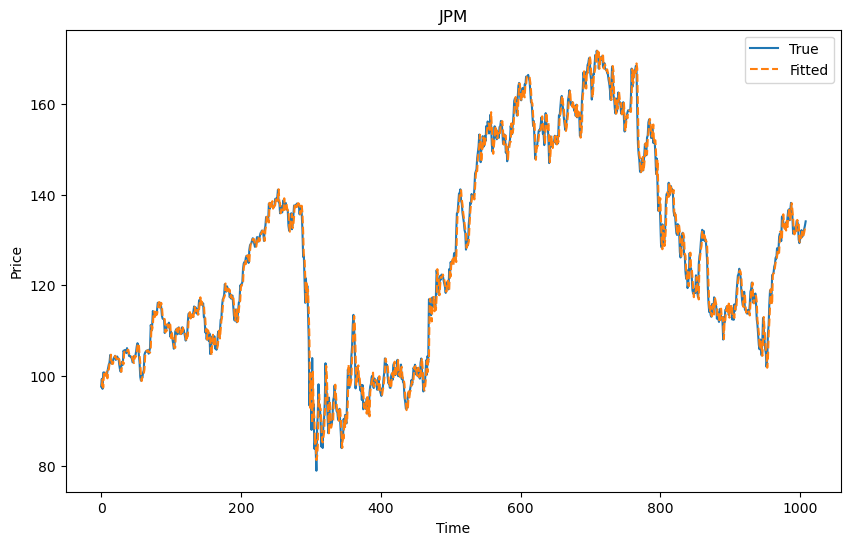

In [23]:
fitted_values = JPM_res.fittedvalues
true_values = JPM['prices']

plt.figure(figsize=(10,6))
plt.plot(true_values, label='True')
plt.plot(fitted_values[1:], label='Fitted',linestyle='--')
plt.title('JPM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

#### Visualize the residuals 

In [25]:
def plot_diagnosticsTight3(data):

    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
    
    ax1.hist(data, bins =40,color='m', density = True)  
    mu = data.mean()
    sigma = data.std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
    ax1.plot(x, stats.norm.pdf(x, mu, sigma), linewidth= 5)
    ax1.grid()
    ax1.set_title("Hist Resid")
    
    ax2.plot(data)
    ax2.grid()
    ax2.set_title("Resid")
    
    fig = plot_acf(data,lags=40,zero=False, ax = ax3,use_vlines = True)
    ax3.grid()
    
    fig = sm.qqplot(data, line='q', ax = ax4)
    ax4.grid()
    
    plt.tight_layout()

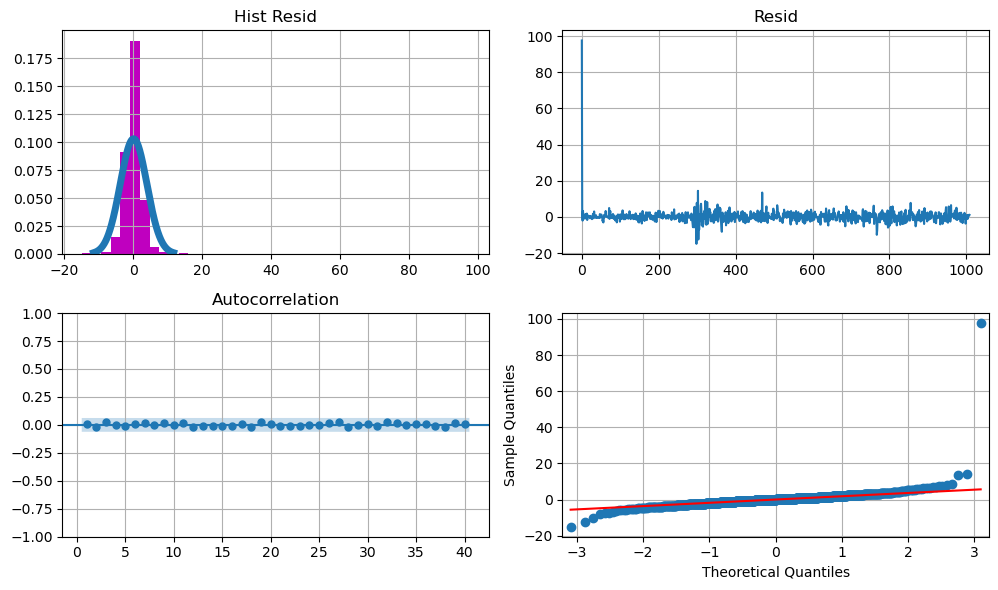

In [26]:
JPMresid = JPM_res.resid
plot_diagnosticsTight3(JPMresid)

In [27]:
JPM_df = pd.concat([JPM, JPM_test], axis=0, ignore_index=True)
data = JPM_df.filter(['prices'])
data

,prices
0,97.620003
1,99.309998
2,97.110001
3,100.690002
4,100.760002
...,...
1254,167.399994
1255,168.389999
1256,169.399994
1257,170.300003


In [28]:
dataset = data.values
train = data[:1009]
test = data[1009:]

#### JPM out-of-sample result 

RMSE: 1.807033831043176


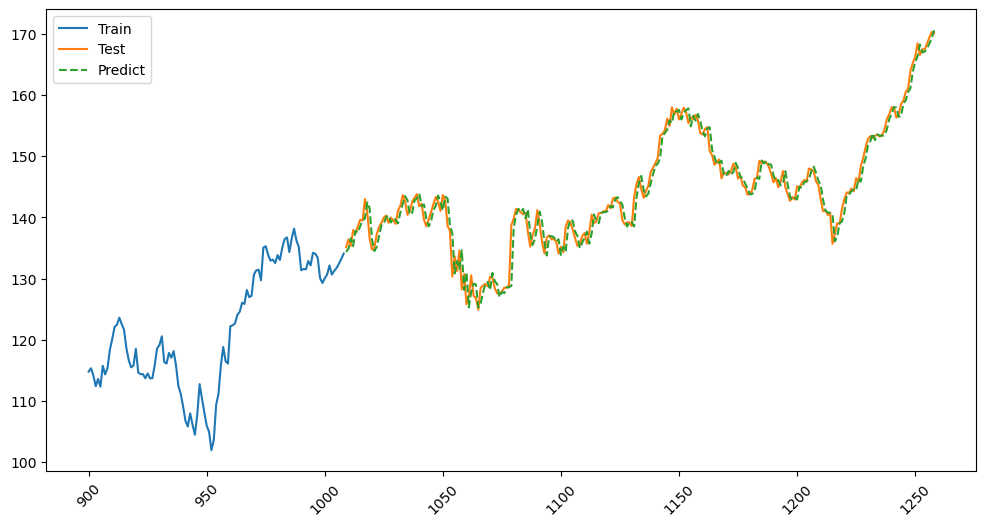

In [30]:
history = list(train.values)
forecast = list()
for t in range(len(test.values)):
	model = ARIMA(history, order=(3,1,2))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	forecast.append(yhat)
	obs = test.iloc[t]
	history.append(obs) 
    
predict = pd.Series(forecast, index=test.index)
mse = mean_squared_error(test['prices'].values, forecast)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

plt.figure(figsize=(12, 6))
plt.plot(train[900:].index, train[900:], label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(predict.index, predict, label='Predict', linestyle='--')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### NVDA ARIMA Model

In [32]:
NVDAseries = NVDA['prices_diff'].dropna()
searchARMA(NVDAseries, max_p=6, max_q =6)

p: 0, q: 1, AIC: 1547.33, BIC: 1557.16
p: 0, q: 2, AIC: 1548.56, BIC: 1563.31
p: 0, q: 3, AIC: 1550.12, BIC: 1569.78
p: 0, q: 4, AIC: 1551.29, BIC: 1575.87
p: 0, q: 5, AIC: 1547.23, BIC: 1576.73
p: 1, q: 0, AIC: 1547.45, BIC: 1557.29
p: 1, q: 1, AIC: 1548.93, BIC: 1563.68
p: 1, q: 2, AIC: 1546.53, BIC: 1566.19
p: 1, q: 3, AIC: 1549.77, BIC: 1574.35
p: 1, q: 4, AIC: 1549.83, BIC: 1579.33
p: 1, q: 5, AIC: 1545.86, BIC: 1580.27
p: 2, q: 0, AIC: 1548.51, BIC: 1563.25
p: 2, q: 1, AIC: 1546.38, BIC: 1566.05
p: 2, q: 2, AIC: 1546.56, BIC: 1571.14
p: 2, q: 3, AIC: 1549.07, BIC: 1578.56
p: 2, q: 4, AIC: 1550.84, BIC: 1585.25
p: 2, q: 5, AIC: 1547.83, BIC: 1587.15
p: 3, q: 0, AIC: 1550.19, BIC: 1569.86
p: 3, q: 1, AIC: 1548.28, BIC: 1572.86
p: 3, q: 2, AIC: 1549.29, BIC: 1578.78
p: 3, q: 3, AIC: 1543.80, BIC: 1578.21
p: 3, q: 4, AIC: 1549.09, BIC: 1588.41
p: 3, q: 5, AIC: 1545.89, BIC: 1590.13
p: 4, q: 0, AIC: 1551.00, BIC: 1575.58
p: 4, q: 1, AIC: 1549.68, BIC: 1579.17
p: 4, q: 2, AIC: 1549.81,

In [33]:
auto_model = auto_arima(NVDA['prices'], trace=True, error_action='ignore', suppress_warnings=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1548.072, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1549.009, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1548.945, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1548.817, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1547.474, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1550.399, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.225 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1009
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -772.737
Date:                Tue, 10 Dec 2024   AIC                           1547.474
Time:                        23:03:57   BIC                           1552.390
Sample:                             0   HQIC                          1549.342
          

In [34]:
NVDAmodel = ARIMA(NVDA['prices'], order=(5,1,4))
NVDA_res = NVDAmodel.fit()
print(NVDA_res.summary())

                               SARIMAX Results                                
Dep. Variable:                 prices   No. Observations:                 1009
Model:                 ARIMA(5, 1, 4)   Log Likelihood                -759.919
Date:                Tue, 10 Dec 2024   AIC                           1539.837
Time:                        23:03:58   BIC                           1588.994
Sample:                             0   HQIC                          1558.513
                               - 1009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7095      0.107      6.611      0.000       0.499       0.920
ar.L2         -0.2485      0.140     -1.776      0.076      -0.523       0.026
ar.L3         -0.4338      0.139     -3.115      0.0

#### NVDA in-sample result

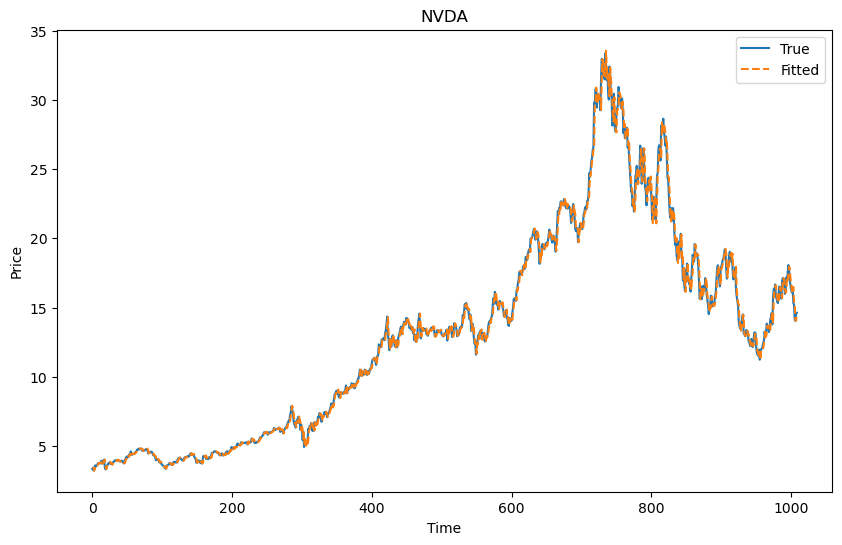

In [36]:
fitted_values = NVDA_res.fittedvalues
true_values = NVDA['prices']

plt.figure(figsize=(10,6))
plt.plot(true_values, label='True')
plt.plot(fitted_values[1:], label='Fitted',linestyle='--')
plt.title('NVDA')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

#### Visualize the residuals 

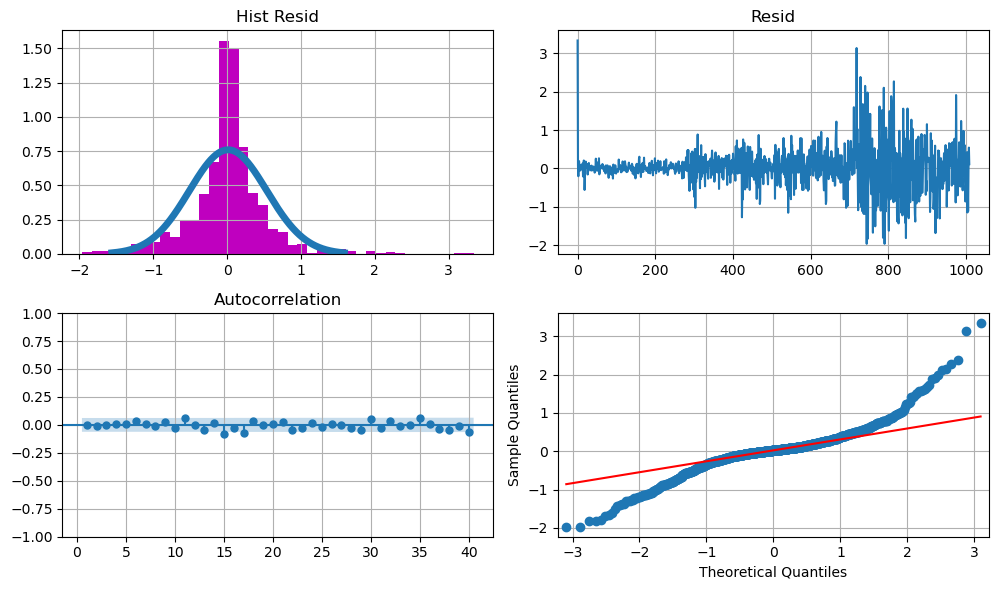

In [38]:
NVDAresid = NVDA_res.resid
plot_diagnosticsTight3(NVDAresid)

In [39]:
NVDA_df = pd.concat([NVDA, NVDA_test], axis=0, ignore_index=True)
data = NVDA_df.filter(['prices'])
data

,prices
0,3.337500
1,3.405500
2,3.199750
3,3.404750
4,3.585000
...,...
1254,48.830002
1255,49.278999
1256,49.417000
1257,49.521999


In [40]:
dataset = data.values
train = data[:1009]
test = data[1009:]

#### NVDA out-of-sample result

RMSE: 1.0446472218547738


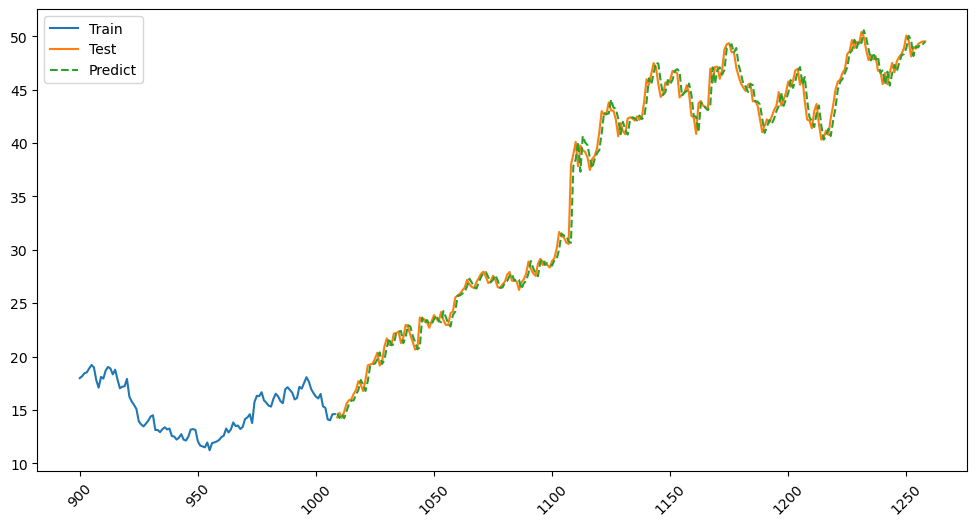

In [42]:
history = list(train.values)
forecast = list()
for t in range(len(test.values)):
	model = ARIMA(history, order=(5,1,4))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	forecast.append(yhat)
	obs = test.iloc[t]
	history.append(obs) 
    
predict = pd.Series(forecast, index=test.index)
mse = mean_squared_error(test['prices'].values, forecast)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

plt.figure(figsize=(12, 6))
plt.plot(train[900:].index, train[900:], label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(predict.index, predict, label='Predict', linestyle='--')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### JPM LSTM model

In [44]:
data = JPM_df.filter(['prices'])
dataset = data.values

In [45]:
scaler = MinMaxScaler(feature_range=(0,1))
traindata = dataset[0:1009, :]
train_data = scaler.fit_transform(traindata)

x_train = []
y_train = []

for i in range(20, len(train_data)):
    x_train.append(train_data[i-20:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 21:
        print(x_train)
        print(y_train)
        print()
        
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.20043131, 0.21865228, 0.19493263, 0.23353104, 0.23428575,
       0.23223721, 0.23040434, 0.2302965 , 0.22512135, 0.23622645,
       0.24420487, 0.25304584, 0.25757412, 0.27557949, 0.2577898 ,
       0.25498654, 0.25563341, 0.26264152, 0.26792451, 0.27105121])]
[0.2736388666610513]

[array([0.20043131, 0.21865228, 0.19493263, 0.23353104, 0.23428575,
       0.23223721, 0.23040434, 0.2302965 , 0.22512135, 0.23622645,
       0.24420487, 0.25304584, 0.25757412, 0.27557949, 0.2577898 ,
       0.25498654, 0.25563341, 0.26264152, 0.26792451, 0.27105121]), array([0.21865228, 0.19493263, 0.23353104, 0.23428575, 0.23223721,
       0.23040434, 0.2302965 , 0.22512135, 0.23622645, 0.24420487,
       0.25304584, 0.25757412, 0.27557949, 0.2577898 , 0.25498654,
       0.25563341, 0.26264152, 0.26792451, 0.27105121, 0.27363887])]
[0.2736388666610513, 0.2638275064226753]



In [46]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(
    x_train, 
    y_train, 
    batch_size=16, 
    epochs=100, 
    validation_split=0.2
)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 199ms/step - loss: 0.0577 - val_loss: 0.0031
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0030 - val_loss: 0.0040
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/st

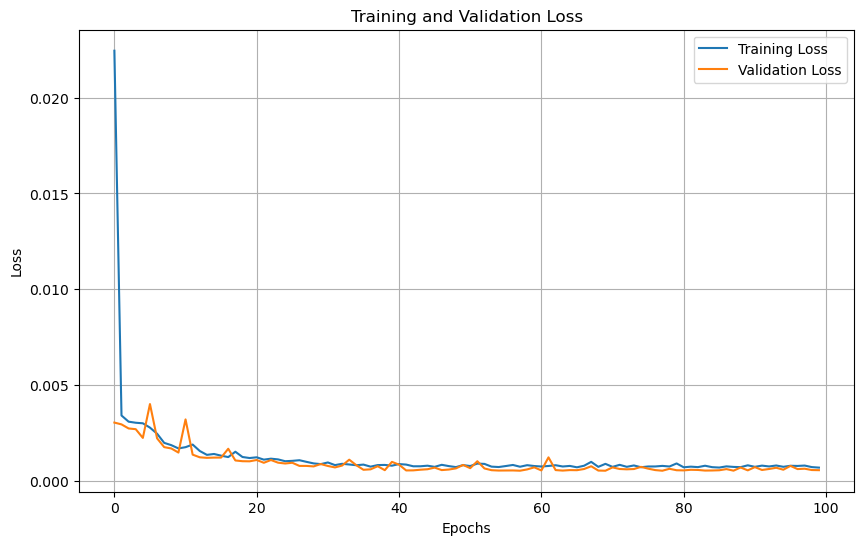

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
testdata = dataset[1009 - 20: , :]
test_data = scaler.transform(testdata)

x_test = []
y_test = dataset[1009:, :]

for i in range(20, len(test_data)):
    x_test.append(test_data[i-20:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


1.881560380746158

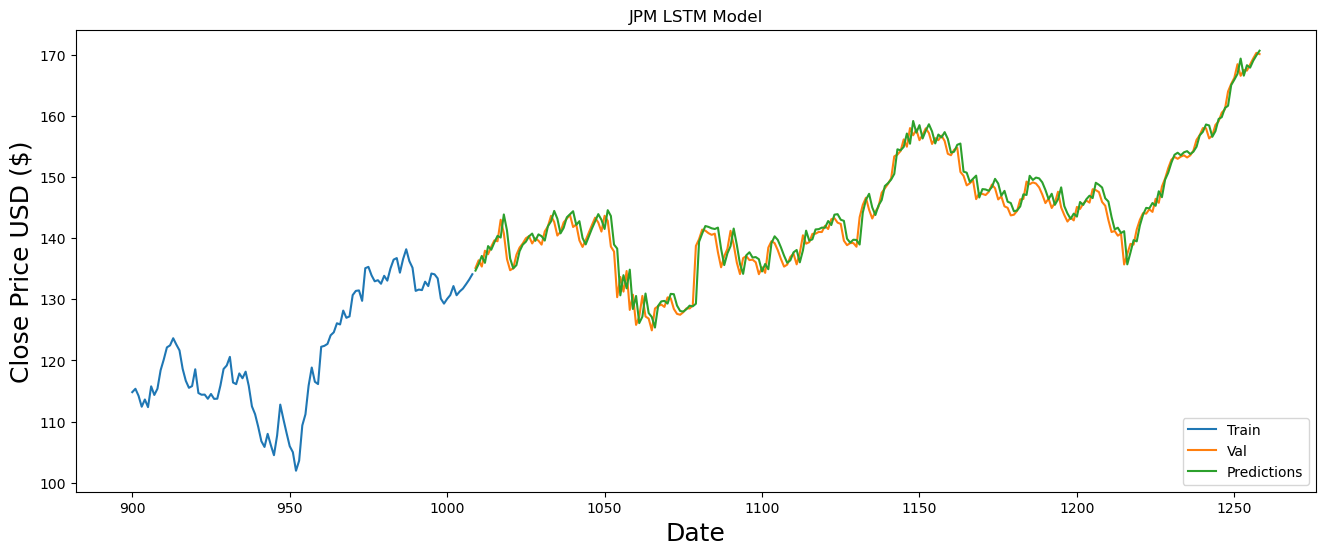

In [49]:
train = data[:1009]
valid = data[1009:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,6))
plt.title('JPM LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['prices'][900:])
plt.plot(valid[['prices', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

### JPM GRU Model

In [51]:
from tensorflow.keras.models import load_model

model = load_model('JPM_GRU.keras')

In [52]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step 


1.8298619297999623

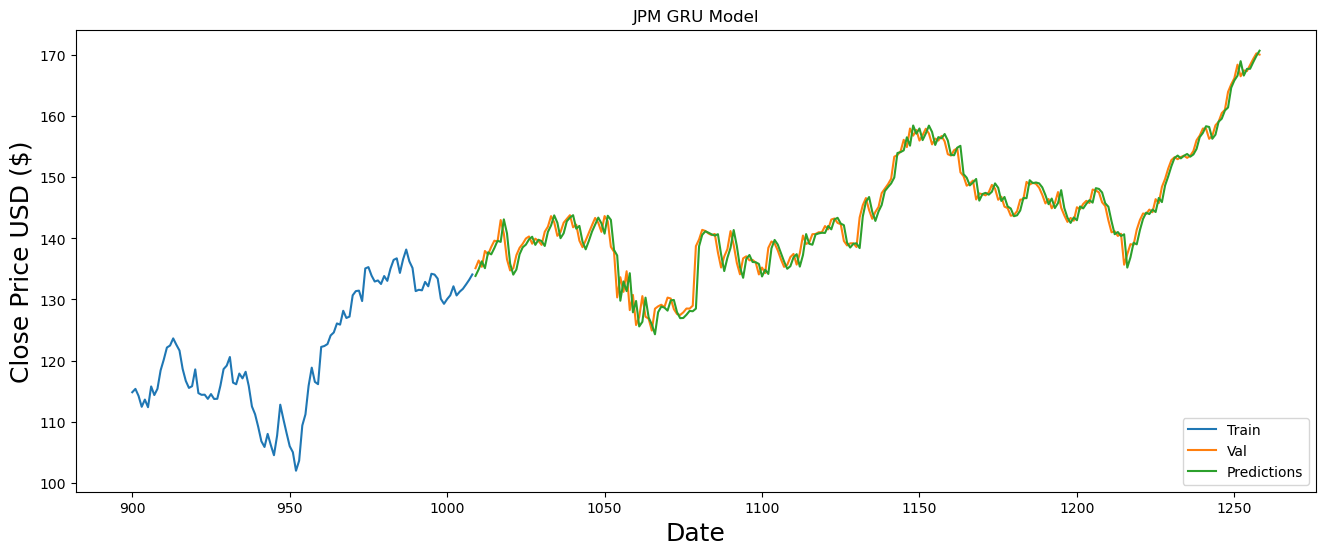

In [53]:
train = data[:1009]
valid = data[1009:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,6))
plt.title('JPM GRU Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['prices'][900:])
plt.plot(valid[['prices', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

### NVDA LSTM Model

In [55]:
data = NVDA_df.filter(['prices'])
dataset = data.values

In [56]:
scaler = MinMaxScaler(feature_range=(0,1))
traindata = dataset[0:1009, :]
train_data = scaler.fit_transform(traindata)

x_train = []
y_train = []

for i in range(10, len(train_data)):
    x_train.append(train_data[i-10:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 11:
        print(x_train)
        print(y_train)
        print()

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.00456485, 0.00681828, 0.        , 0.00679343, 0.01276667,
       0.00980904, 0.01208733, 0.01428276, 0.01726524, 0.01859906])]
[0.018126844082459667]

[array([0.00456485, 0.00681828, 0.        , 0.00679343, 0.01276667,
       0.00980904, 0.01208733, 0.01428276, 0.01726524, 0.01859906]), array([0.00681828, 0.        , 0.00679343, 0.01276667, 0.00980904,
       0.01208733, 0.01428276, 0.01726524, 0.01859906, 0.01812684])]
[0.018126844082459667, 0.017273518681176922]



In [114]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(
    x_train, 
    y_train, 
    batch_size=16, 
    epochs=100, 
    validation_split=0.2
)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0314 - val_loss: 0.0029
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.0308e-04 - val_loss: 0.0022
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.9454e-04 - val_loss: 0.0022
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.2506e-04 - val_loss: 0.0023
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.4637e-04 - val_loss: 0.0020
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.9011e-04 - val_loss: 0.0028
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.9177e-04 - val_loss: 0.0020
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.7931e-04 - val_loss: 0.0019
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.2994e-04 - val_loss: 0.0018
Epoch 12/100
50/50 ━━

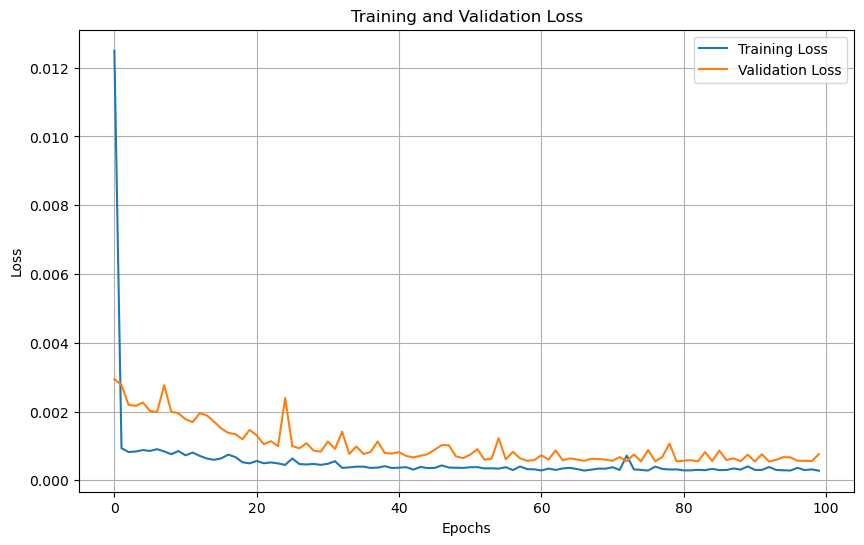

In [116]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [118]:
testdata = dataset[1009 - 10: , :]
test_data = scaler.transform(testdata)

x_test = []
y_test = dataset[1009:, :]

for i in range(10, len(test_data)):
    x_test.append(test_data[i-10:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


1.7146458755340999

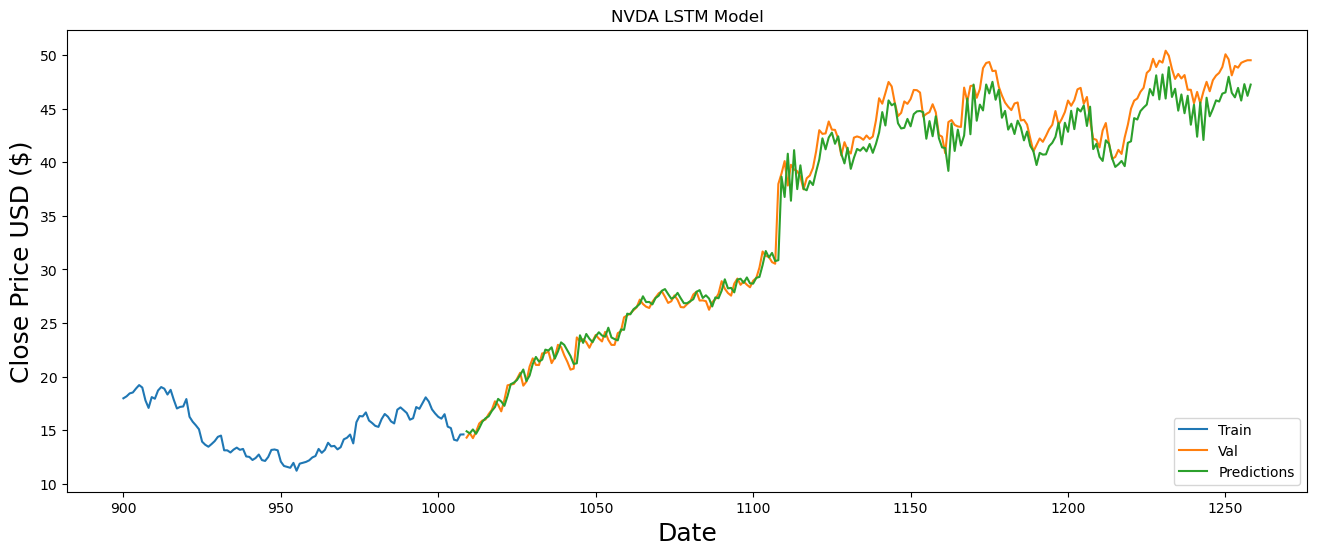

In [120]:
valid['Predictions'] = predictions
plt.figure(figsize=(16,6))
plt.title('NVDA LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['prices'][900:])
plt.plot(valid[['prices', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

### NVDA GRU Model

In [123]:
model = load_model('NVDA_GRU.keras')

In [125]:
train = data[:1009]
valid = data[1009:]
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


1.0930318804932204

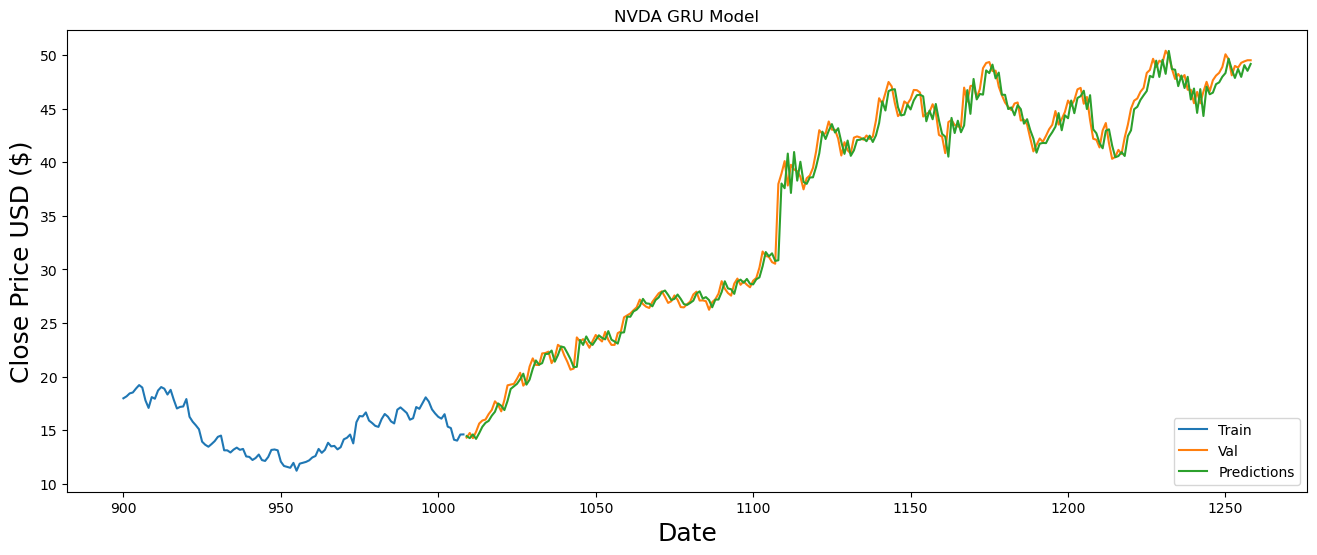

In [126]:
valid['Predictions'] = predictions
plt.figure(figsize=(16,6))
plt.title('NVDA GRU Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['prices'][900:])
plt.plot(valid[['prices', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()